In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os.path as path
import sys
from deepretina.experiments import loadexpt
import pickle
from BN_CNN import BNCNN
import metrics
import matplotlib.pyplot as plt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle

Loading training data for 15-10-07/naturalscene... Done.
Loading testing data for 15-10-07/naturalscene... Done.


## If used metrics

In [44]:
with open("Trained_12_04_18/metrics", "rb") as fd:
    metrics = pickle.load(fd)

Text(0.5,0,'Epoch')

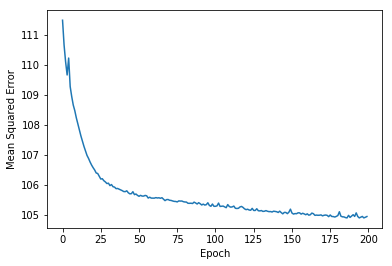

In [45]:
plt.plot(metrics['mse'])
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')

Text(0.5,0,'Epoch')

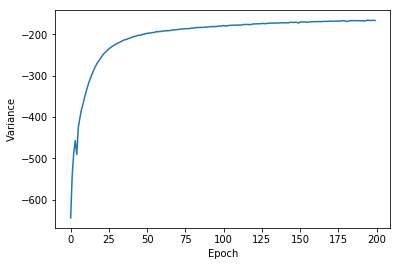

In [46]:
plt.plot(metrics['var'])
plt.ylabel('Variance')
plt.xlabel('Epoch')

In [2]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [3]:
# load the losses
losses = []
for i in range(200):
    file = "Trained 2019_02_07/test_epoch_{0}.pth".format(i)
    with open(file, "rb") as fd:
        temp = torch.load(fd)
    losses.append(temp['loss'])


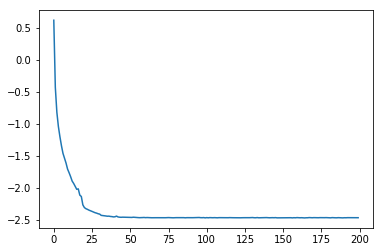

In [4]:
plt.plot(losses)

In [5]:
bn_cnn = temp['model']

In [6]:
bn_cnn = bn_cnn.to(DEVICE)
bn_cnn.eval()

BNCNN(
  (conv1): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
  (batch1): BatchNorm1d(10368, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
  (batch2): BatchNorm1d(5408, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=5408, out_features=5, bias=False)
  (batch3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [7]:
test_data = loadexpt('15-10-07',[0,1,2,3,4],'naturalscene','test',40,0)

Loading testing data for 15-10-07/naturalscene... Done.


In [8]:
train_data = loadexpt('15-10-07',[0,1,2,3,4],'naturalscene','train',40,0)

Loading training data for 15-10-07/naturalscene... Done.


In [19]:
train_data.X.shape

(359762, 40, 50, 50)

In [9]:
test_x = torch.from_numpy(test_data.X)
physio = Physio(bn_cnn)

In [10]:
model_response = bc.batch_compute_model_response(test_data.X, bn_cnn, 500)

In [11]:
model_response.keys()

dict_keys(['stimulus', 'conv2d_1', 'flatten_1', 'batch_normalization_1', 'gaussian_1', 'activation_1', 'conv2d_2', 'flatten_2', 'batch_normalization_2', 'gaussian_2', 'activation_2', 'dense', 'batch_normalization_3', 'activation_3'])

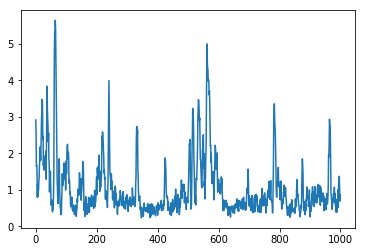

In [12]:
plt.plot(model_response['activation_3'][:1000, 0])

In [13]:
# average retinal ganglion cell correlation
np.mean([scipy.stats.pearsonr(model_response['activation_3'][:, i], test_data.y[:, i])[0] for i in range(5)])

0.6472983216268473

# Retinal Phenomena

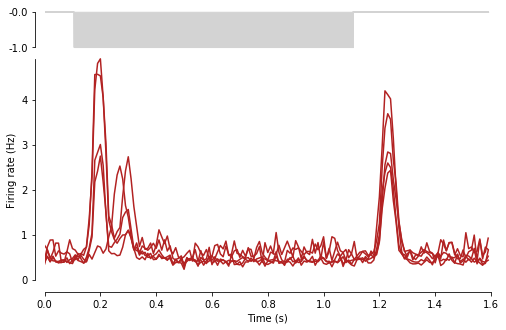

In [24]:
figs, X, resp= rp.step_response(bn_cnn)

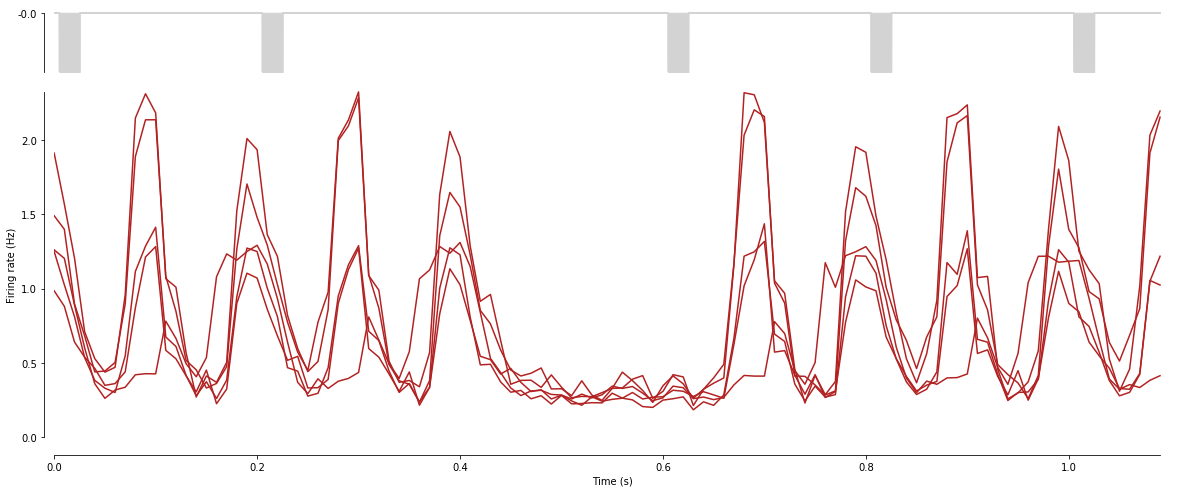

In [25]:
figs, X, resp = rp.osr(bn_cnn)

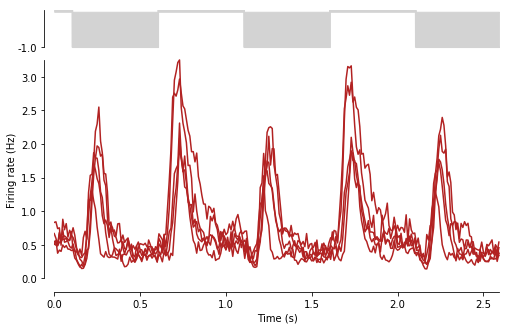

In [26]:
figs, X, resp = rp.reversing_grating(bn_cnn)

100%|██████████| 10/10 [00:00<00:00, 40.19it/s]


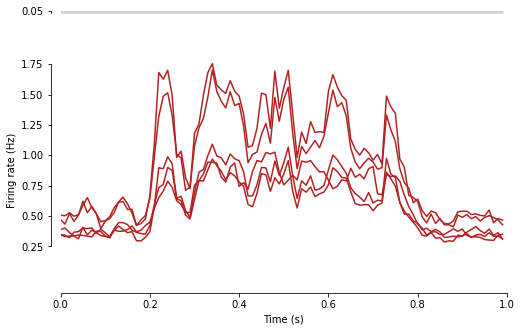

In [27]:
figs, X, resp = rp.contrast_adaptation(bn_cnn, .05, .35)

51it [00:00, 109.79it/s]


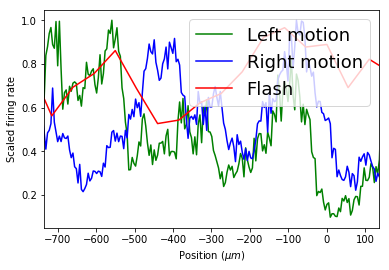

In [28]:
(fig, ax), (c_right, stim_right, resp_right), (c_left, stim_left, resp_left), (flash_centers, flash_responses) = rp.motion_anticipation(bn_cnn)

# Intracellular Stuff

In [18]:
#If you want to use stimulus that isnt just boxes
def prepare_stim(stimuli, stim_type):
    if stim_type == 'boxes':
        return stimuli
    elif stim_type == 'flashes':
        stim = stimuli.reshape(stimuli.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stimuli, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    else:
        return None

In [19]:
#Load data
# num_pots stores the number of cells per stimulus
# mem_pots stores the membrane potential
files = ['../data/bipolars_late_2012.h5', '../data/bipolars_early_2012.h5', '../data/amacrines_early_2012.h5', '../data/amacrines_late_2012.h5', '../data/horizontals_early_2012.h5', '../data/horizontals_late_2012.h5']
file_ids = []
for f in files:
    file_ids.append(re.split('_|\.', f)[0])
filter_length = 40
window_size = 2
stims = []
mem_pots = []
num_pots = []
for fi in files:
    with h5.File(fi, 'r') as f:
        num = np.array(f['boxes/detrended_membrane_potential'].shape[0])
        num_pots.append(num)
        stims.append(prepare_stim(np.array(f['boxes/stimuli']), 'boxes'))
        mem_pots.append(np.array(f['boxes/detrended_membrane_potential'])[:, filter_length:])

In [20]:
# Computes the model responses for each stimulus 
# and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
y_true = []
filter_length = 40
model_responses = []
for i in range(len(files)):
    file_name = files[i]
    if 'bipolar' in file_name:
        for j in range(num_pots[i]):
            y_true.append(0)
    elif 'amacrine' in file_name:
        for j in range(num_pots[i]):
            y_true.append(1)
    else:
        for j in range(num_pots[i]):
            y_true.append(2)
    stim = stims[i]
    padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
    model_responses.append(bc.batch_compute_model_response(stimuli.concat(padded_stim),bn_cnn,  500))

In [22]:
# uses classify to get the most correlated cell/layer/subtype for each interneuron recording. Stored in all_cell_info
# y_pred does a baseline "classification": record the convolutional layer that the most correlated cell is in.
# See intracellular.py for more info
# This takes a really long time to run. 
all_cell_info = []
y_pred = []
for i in range(len(files)):
    for j in range(mem_pots[i].shape[0]):
        model_response = model_responses[i]
        stim = stims[i]
        potential = mem_pots[i][j]
        cell_info = intracellular.classify(potential, model_response, stim.shape[0])
        all_cell_info.append(cell_info)
        layer = cell_info[0]
        if layer == 'conv2d_1':
            y_pred.append(0)
        else:
            y_pred.append(1)

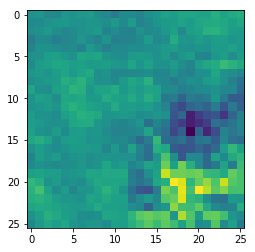

In [43]:
# Make correlation maps
model_response = model_responses[3]
potential = mem_pots[3][4]
plt.imshow(intracellular.correlation_map(potential, model_response['conv2d_2'][:, 4]))

In [23]:
# Average intracellular correlation. RIP.
np.mean([all_cell_info[i][3] for i in range(7)])

0.3687540236976893

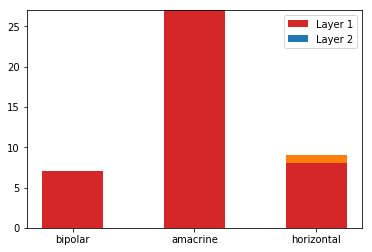

In [24]:
bipolar_layer1 = 0
bipolar_layer2 = 0
amacrine_layer1 = 0
amacrine_layer2 = 0
horizontal_layer1 = 0
horizontal_layer2 = 0
for index in range(len(y_true)):
    if y_true[index] == 0 and y_pred[index] == 0:
        bipolar_layer1 += 1
    elif y_true[index] == 0 and y_pred[index] == 1:
        bipolar_layer2 += 1
    elif y_true[index] == 1 and y_pred[index] == 0:
        amacrine_layer1 += 1
    elif y_true[index] == 1 and y_pred[index] == 1:
        amacrine_layer2 += 1
    elif y_true[index] == 2 and y_pred[index] == 0:
        horizontal_layer1 += 1
    else:
        horizontal_layer2 += 1
    
layer1 = [bipolar_layer1, amacrine_layer1, horizontal_layer1]
layer2 = [bipolar_layer2, amacrine_layer2, horizontal_layer2]
ind = np.arange(3)
width = 0.5
p1 = plt.bar(ind, layer1, width, color='#d62728')
p2 = plt.bar(ind, layer2, width,
             bottom=layer1)
p3 = plt.bar(ind, layer2, width, bottom=layer1)
plt.xticks(ind, ('bipolar', 'amacrine', 'horizontal'))
plt.legend((p1[0], p2[0]), ('Layer 1', 'Layer 2'))
plt.show()

In [26]:
stimulus_num = 3
model_cell_response = model_responses[stim]['conv2d_2'][:, 1, 15, 0]
stimulus = stims[3]

In [27]:
filter_length = 40

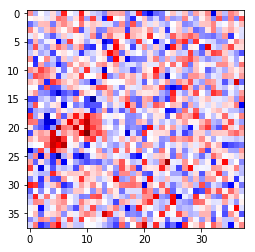

In [28]:
# Plot the receptive field for a model cell
rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, nsamples_before=0, nsamples_after=filter_length)
spatial_model, temporal_model = ft.decompose(rc_model)
img =plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), np.max(abs(spatial_model))])